In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from models.mnist_model import  MemoryAutoEncoder

## Dataset

In [2]:
def get_dataloaders(digit_class):
    """
    This will allow us to get a train dataset with only one digit class
    and a test loader with digits from all classes. Those digit from a class other than digit_class
    would be the anomalies.
    :param digit_class: The digit, i.e. 0-9
    :return: train and test loaders
    """
    single_class_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=False,
        transform=transforms.ToTensor()
    )
    idx = single_class_dataset.targets == digit_class
    single_class_dataset.data = single_class_dataset.data[idx]
    single_class_dataset.targets = single_class_dataset.targets[idx]

    train_loader = DataLoader(
        single_class_dataset,
        batch_size=64,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.MNIST(
            root='./data',
            train=False,
            download=False,
            transform=transforms.ToTensor()
        ),
        batch_size=64,
        shuffle=True
    )

    return train_loader, test_loader

In [3]:
ID_CLASS = 2
train, test = get_dataloaders(ID_CLASS)
print("Shape of train data: ", train.dataset.data.shape)
print("Shape of test data: ", test.dataset.data.shape)

print("There are {}% of samples from class {} in the test set".format(
    round(test.dataset.targets[test.dataset.targets == ID_CLASS].shape[0] / test.dataset.targets.shape[0] * 100, 2),
    ID_CLASS
))

Shape of train data:  torch.Size([5958, 28, 28])
Shape of test data:  torch.Size([10000, 28, 28])
There are 10.32% of samples from class 2 in the test set


In [4]:
model = MemoryAutoEncoder(n=100, c=256)
n_epochs = 100
lr = 1e-3
alpha = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse_criterion = torch.nn.MSELoss(reduction='mean')

def entropy_criterion(w):
    return torch.sum(-w * torch.log(w + 1e-12), dim=1).mean()

Train Epoch: 0 [0/5958 (0%)]	Loss MSE: 1.48	 Entropy Loss: 3.90
Train Epoch: 1 [0/5958 (0%)]	Loss MSE: 0.06	 Entropy Loss: 3.73
Train Epoch: 2 [0/5958 (0%)]	Loss MSE: 0.05	 Entropy Loss: 3.80
Train Epoch: 3 [0/5958 (0%)]	Loss MSE: 0.04	 Entropy Loss: 3.78
Train Epoch: 4 [0/5958 (0%)]	Loss MSE: 0.04	 Entropy Loss: 3.80
Train Epoch: 5 [0/5958 (0%)]	Loss MSE: 0.04	 Entropy Loss: 3.78
Train Epoch: 6 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.77
Train Epoch: 7 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.78
Train Epoch: 8 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.79
Train Epoch: 9 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.81
Train Epoch: 10 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.77
Train Epoch: 11 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.81
Train Epoch: 12 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.80
Train Epoch: 13 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.81
Train Epoch: 14 [0/5958 (0%)]	Loss MSE: 0.03	 Entropy Loss: 3.79
Train Epoch: 15 [0/5958 (0%)]	Loss 

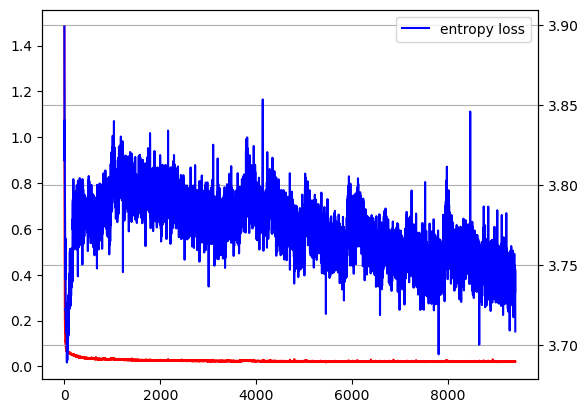

In [5]:
loss_record = {'mse': [], 'entropy': []}
for epoch in range(n_epochs):
    for batch_idx, (data, _) in enumerate(train):
        optimizer.zero_grad()
        output, w = model(data)
        #print(" max w", w.max())

        mse_loss = mse_criterion(output, data)
        entropy_loss = entropy_criterion(w)
        loss = mse_loss + alpha*entropy_loss
        loss.backward()
        optimizer.step()

        loss_record['mse'].append(mse_loss.item())
        loss_record['entropy'].append(entropy_loss.item())

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss MSE: {:.2f}\t Entropy Loss: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train.dataset),
                       100. * batch_idx / len(train), mse_loss.item(), entropy_loss.item()),

            )

# Plot loss
fig, ax = plt.subplots()
ax.plot(loss_record['mse'], label='mse loss', color='red')
# Second axis
twax = ax.twinx()
twax.plot(loss_record['entropy'], label='entropy loss', color='blue')
plt.grid()
plt.legend(loc='best')
plt.show()

Reconstruction error:  tensor(956.9925)


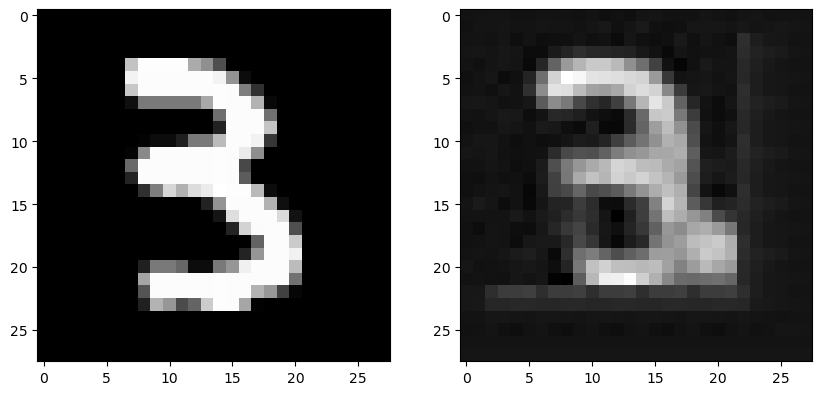

In [25]:
test_input = next(iter(test))[0]
test_out, _ = model(test_input)

 # Calculare reconstruction error
# make values for test_output {0, 1}
#test_out = torch.where(test_out > 0, torch.ones_like(test_out), torch.zeros_like(test_out))
#test_input = torch.where(test_input > 0, torch.ones_like(test_input), torch.zeros_like(test_input))
r_error = (torch.sqrt(torch.sum(test_input - test_out)**2)).detach()
# Plot input and output in the same plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_input[0].squeeze().detach().numpy(), cmap='gray')
ax[1].imshow(test_out[0].squeeze().detach().numpy(), cmap='gray')
# Add reconstruction error to the plot
print("Reconstruction error: ", r_error)
plt.show()

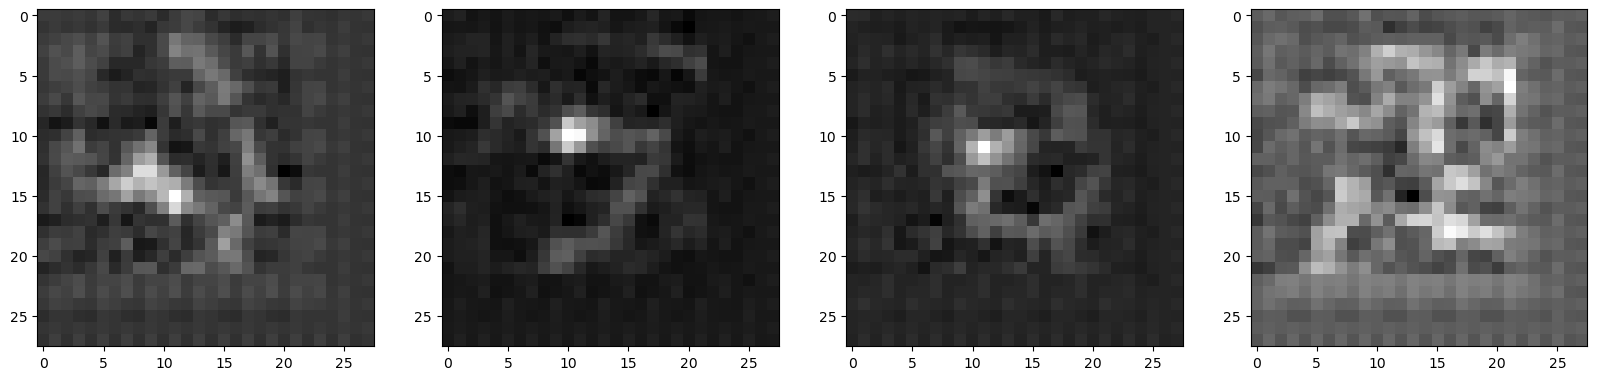

In [26]:
# Plot some slots of the memory
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    i_slot = model.memory[i+25].detach().unsqueeze(0)
    # Decode
    i_slot = model.decoder(i_slot)
    ax[i].imshow(i_slot[0].squeeze().detach().numpy(), cmap='gray')

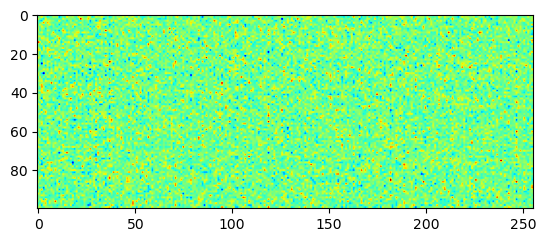

In [27]:
# Plot memory
plt.imshow(model.memory.detach().numpy(), cmap='jet')